# Getting the Model

First we install the requirements as mentioned in the README.md file.

In [61]:
#pip install -r requirements.txt

Import all the dependencies needed for the predict function.

In [85]:
from predict import *

In [86]:
test_student = {
        "student_id": "student1",
        "major": "Computer Science",
        "age": "20",
        "gender": "M",
        "gpa": "4.0",
        "extra_curricular": "Men's Basketball",
        "num_programming_languages": "1",
        "num_past_internships": "2"
    }

In [87]:
predict(test_student)

{'good_employee': 1}

# Evaluating Model Performance & Fairness

Since we don't know how the model provided in the draft pull request was trained, we want to evaluate it before implementing it into NodeBB. In the rest of the notebook, we will be evaluating the model's performance and fairness.

The engineer who created the model made the following assumptions:
- The model is used to predict whether a student will be a good candidate for a software engineering job.
- It is a binary classifier, where 1 means the student is a good candidate, and 0 means the student is not a good candidate.
- The model is trained on a dataset of students who have graduated from CMU, and have been working in the industry for at least 1 year.
- In order to prevent bias, they assumed that removing Gender (M, F) and Student ID from the dataset would be sufficient when it comes to training the model. They claimed that it is now Group Unaware, thus the model would be fair.

The model specification is as follows:

In [67]:
# X variable (input parameters)
# - Age (18 - 25)
# - Major (Computer Science, Information Systems, Business, Math,
#          Electrical and Computer Engineering, Statistics and Machine Learning)
# - GPA (0 - 4.0)
# - Extra Curricular Activities (Student Theatre, Buggy, Teaching Assistant, Student Government,
#     Society of Women Engineers, Women in CS, Volleyball, Sorority, Men's Basketball,
#     American Football, Men's Golf, Fraternity)
# - Number of Programming Languages (1, 2, 3, 4, 5)
# - Number of Past Internships (0, 1, 2, 3, 4)

# Y variable (output)
# - Good Candidate (0, 1)

A test dataset has been provided to us in the following format:

In [68]:
# X variable
# - Student ID
# - Gender (M, F)
# - Age (18 - 25)
# - Major (Computer Science, Information Systems, Business, Math,
#          Electrical and Computer Engineering, Statistics and Machine Learning)
# - GPA (0 - 4.0)
# - Extra Curricular Activities (Student Theatre, Buggy, Teaching Assistant, Student Government,
#     Society of Women Engineers, Women in CS, Volleyball, Sorority, Men's Basketball,
#     American Football, Men's Golf, Fraternity)
#   # Likely Co-Ed (Student Theatre, Buggy, Teaching Assistant, Student Government)
#   # Likely Majority Female (Society of Women Engineers, Women in CS, Volleyball, Sorority)
#   # Likely Majority Male (Men's Basketball, American Football, Men's Golf, Fraternity)
# - Number of Programming Languages (1, 2, 3, 4, 5)
# - Number of Past Internships (0, 1, 2, 3, 4)

# Y variable
# - Good Candidate (0, 1)

This test dataset is a different set of students from the training dataset, and the evaluation of whether the student is a good candidate is done by a fair panel of recruiters, so it can be considered to be unbiased. Additionally, the panel of recruiters have provided us with additional context on the extracurricular activities in comments (marked with #).

## Preliminary Analysis

Before we evaluate the fairness of the model, we want to do a prelimiary analysis on the test dataset.

In [69]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

### Loading the Model and Test Dataset

In [89]:
df = pd.read_csv("student_data.csv")
model = pickle.load(open("model.pkl","rb"))

### Plotting the Distributions of the Test Dataset

Now we want to plot the distribution of the test dataset across all features (except Student ID). We will be using the seaborn library.

In [90]:
df.head()

,Student ID,Gender,Age,Major,GPA,Extra Curricular,Num Programming Languages,Num Past Internships,Good Candidate
0,0,F,21,Statistics and Machine Learning,2.83,Sorority,4,1,0
1,1,M,20,Information Systems,2.89,Fraternity,5,3,0
2,2,F,20,Math,2.66,Teaching Assistant,3,1,0
3,3,M,20,Information Systems,2.48,Fraternity,5,0,0
4,4,F,21,Statistics and Machine Learning,3.30,Sorority,2,1,0


In [91]:
df.describe()

,Student ID,Age,GPA,Num Programming Languages,Num Past Internships,Good Candidate
count,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000
mean,249.500000,20.944000,2.905780,3.04600,2.052000,0.474000
std,144.481833,1.455025,0.839559,1.36073,1.407572,0.499824
min,0.000000,18.000000,0.000000,1.00000,0.000000,0.000000
25%,124.750000,20.000000,2.345000,2.00000,1.000000,0.000000
50%,249.500000,21.000000,2.990000,3.00000,2.000000,0.000000
75%,374.250000,22.000000,3.560000,4.00000,3.000000,1.000000
max,499.000000,25.000000,4.000000,5.00000,4.000000,1.000000


Gender (Categorical - M/F)
- Bar chart: Show the count of each gender category using bars.

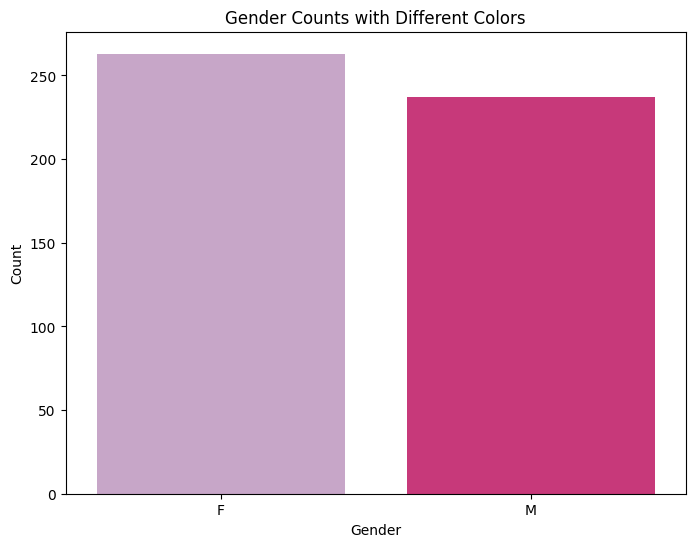

In [97]:
# Assuming you have already computed gender_counts
gender_counts = df["Gender"].value_counts()

custom_palette = "PuRd"

# Plot using Seaborn with different colors for each bar
plt.figure(figsize=(8, 6))
sns.barplot(x=gender_counts.index, y=gender_counts.values, hue=gender_counts.index, palette=custom_palette, legend=False)
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Gender Counts with Different Colors")
plt.show()



Age (Numerical - Integer)
- Histogram: Visualize the distribution of ages using a histogram.

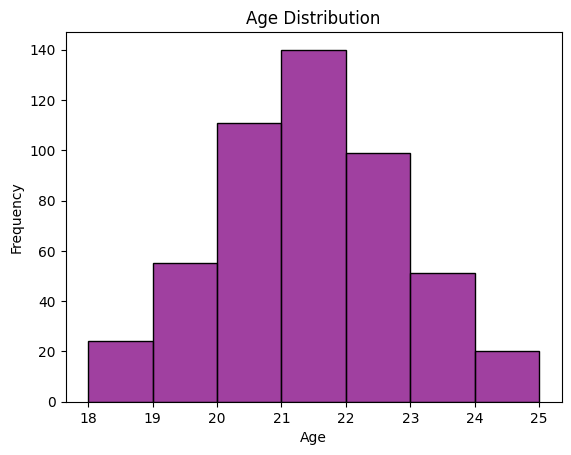

In [98]:
# Create a histogram using Seaborn
sns.histplot(df["Age"], bins=7, color="purple")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Age Distribution")
plt.show()

Major (Categorical - String)
- Bar chart: Show the count of each major category.

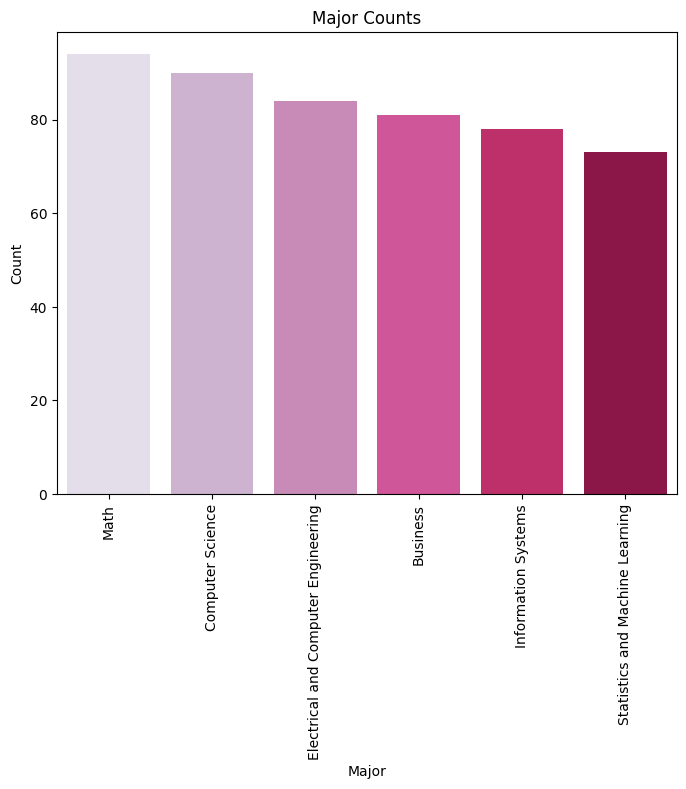

In [101]:
# Count the occurrences of each major category
major_counts = df["Major"].value_counts()

plt.figure(figsize=(8, 6))  # Adjust the figure size as needed

# Create a bar plot
sns.barplot(x=major_counts.index, y=major_counts.values, hue=major_counts.index, palette=custom_palette, legend=False)

# Customize the plot labels and title
plt.xlabel("Major")
plt.ylabel("Count")
plt.title("Major Counts")

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=90)

# Show the plot
plt.show()

GPA (Numerical - Float)
- Histogram: Visualize the distribution of GPAs using a histogram.

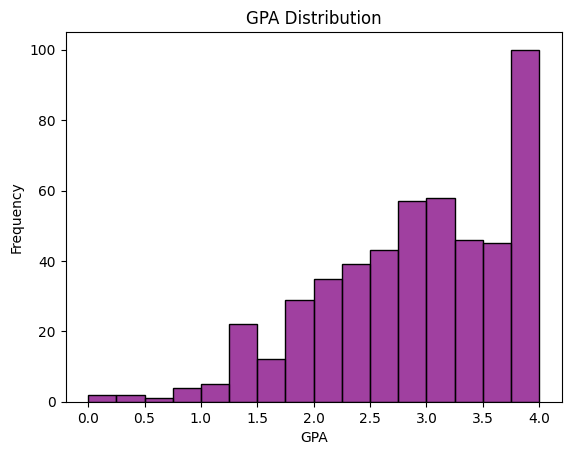

In [102]:
sns.histplot(df["GPA"], bins=16, color="purple")
plt.xlabel("GPA")
plt.ylabel("Frequency")
plt.title("GPA Distribution")
plt.show()

Extra Curricular (Categorical - String)
- Bar chart: Show the count of each type of extracurricular activity.

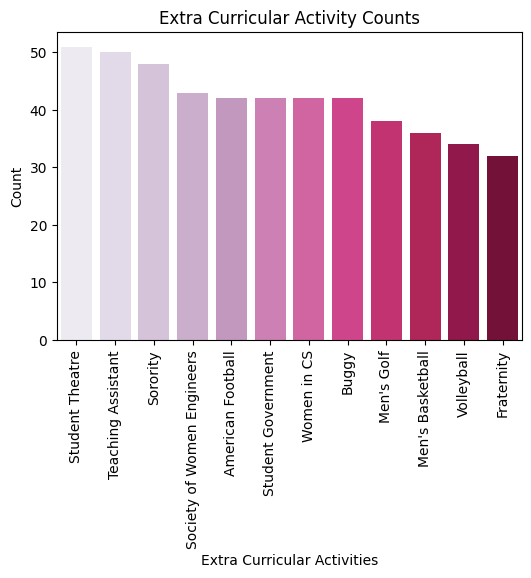

In [116]:
# Count the occurrences of each extra-curricular category
ec = df["Extra Curricular"].value_counts()

plt.figure(figsize=(6, 4))  # Adjust the figure size as needed

# Use a Seaborn palette for colors, for example, "colorblind"

# Create a bar plot
sns.barplot(x=ec.index, y=ec.values, hue=ec.index, palette=custom_palette, legend=False)

# Customize the plot labels and title
plt.xlabel("Extra Curricular Activities")
plt.ylabel("Count")
plt.title("Extra Curricular Activity Counts")

# Rotate x-plotis labels for better readability (optional)
plt.xticks(rotation=90)

# Show the plot
plt.show()

Num Programming Languages (Numerical - Integer)
- Bar chart: Show the count of the number of programming languages.
- Could use a histogram, but the range is not that big.

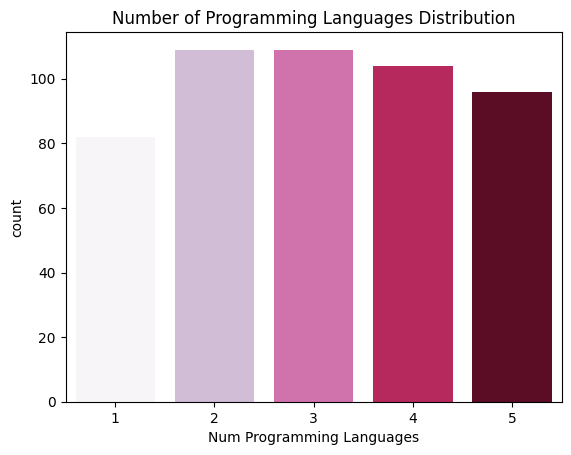

In [117]:
# Create the barplot
sns.countplot(data=df, x="Num Programming Languages", palette=custom_palette, hue="Num Programming Languages", legend=False)
plt.title("Number of Programming Languages Distribution")
plt.show()

Num Past Internships (Numerical - Integer)
- Bar chart: Show the count of the number of past internships.
- Could use a histogram, but the range is not that big.

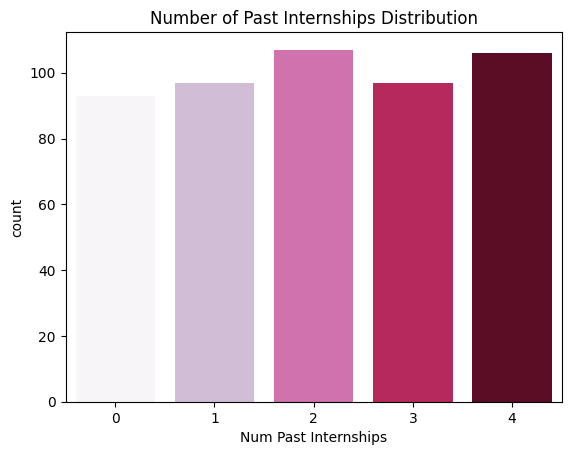

In [119]:
# Create the barplot
sns.countplot(data=df, x="Num Past Internships", palette=custom_palette, hue="Num Past Internships", legend=False)
plt.title("Number of Past Internships Distribution")
plt.show()

Good Candidate (Target - Binary)
- Bar chart: Show the distribution of candidates being classified as "good" (1) or not (0).

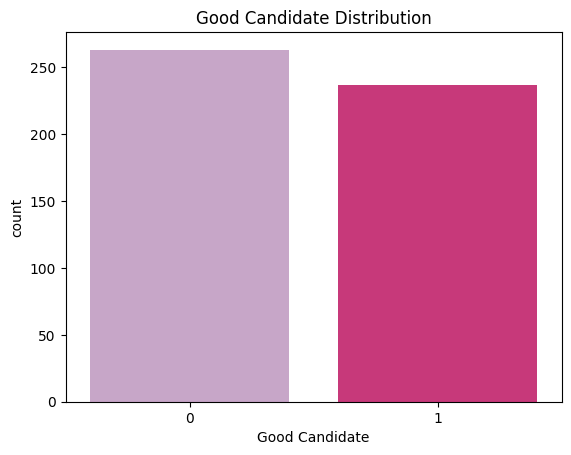

In [120]:
sns.countplot(data=df, x="Good Candidate", palette=custom_palette, hue="Good Candidate", legend=False)
plt.title("Good Candidate Distribution")
plt.show()

## Running the Model

Now we will run the model on the test dataset to get the accuracy of the model.

First, we have to predict the output of the test dataset using the model.

In [81]:
# we split the data into our inputs and the label
test_df = test_df.drop(["Student ID", "Gender"], axis=1)
x_test = test_df.drop(["Good Candidate"], axis=1)
y_test = test_df["Good Candidate"]

In [82]:
y_pred = model.predict(x_test)

Now we can report the accuracy of the model along with the confusion matrix.

In [83]:
# now we can compute the accuracy of those predictions
print('Accuracy Score: ', accuracy_score(y_pred, y_test))

Accuracy Score:  0.832


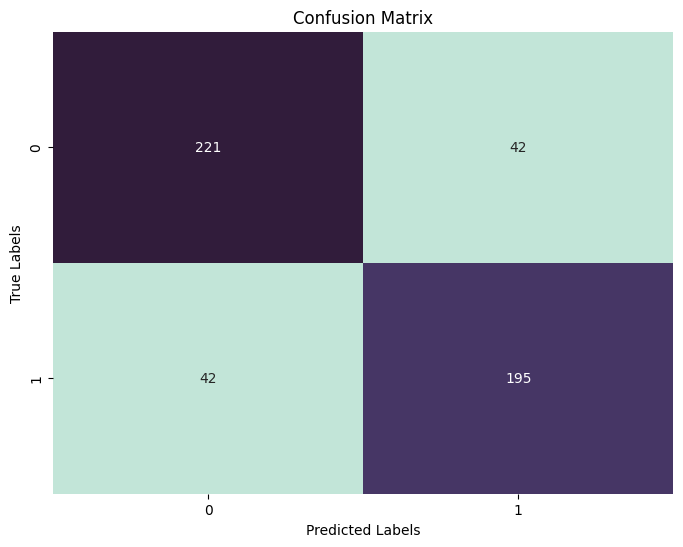

In [84]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True), cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()